In [1]:
# Environment setup 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib
import math
import glob
import json
print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# data loaded
DATA_DIR = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\backend\data'

# Check if files exist
train_file = os.path.join(DATA_DIR, 'train_FD001.txt')
test_file = os.path.join(DATA_DIR, 'test_FD001.txt')
rul_file = os.path.join(DATA_DIR, 'RUL_FD001.txt')

print(f"Train file exists: {os.path.exists(train_file)}")
print(f"Test file exists: {os.path.exists(test_file)}")
print(f"RUL file exists: {os.path.exists(rul_file)}")

Train file exists: True
Test file exists: True
RUL file exists: True


In [ ]:
# read txt (whitespace separated, no header)
def read_cmapss(filepath):
    col_names = (["unit", "cycle",
                  "op_setting_1", "op_setting_2", "op_setting_3"] +
                 [f"s{i}" for i in range(1, 22)])
    df = pd.read_csv(filepath, sep=r"\s+", header=None, names=col_names)
    return df

# Read training data
df_train = read_cmapss(train_file)
print(f"Training data shape: {df_train.shape}")
print(f"Columns: {list(df_train.columns)}")
print(f"\nFirst few rows:")
print(df_train.head())

Training data shape: (20631, 26)
Columns: ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

First few rows:
   unit  cycle  op_setting_1  op_setting_2  op_setting_3      s1      s2  \
0     1      1       -0.0007       -0.0004         100.0  518.67  641.82   
1     1      2        0.0019       -0.0003         100.0  518.67  642.15   
2     1      3       -0.0043        0.0003         100.0  518.67  642.35   
3     1      4        0.0007        0.0000         100.0  518.67  642.35   
4     1      5       -0.0019       -0.0002         100.0  518.67  642.37   

        s3       s4     s5  ...     s12      s13      s14     s15   s16  s17  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392   
2  1587.99  1404.20  14.62  ...  522.42 

In [4]:
# Create RUL (Remaining Useful Life) labels for training data
def add_rul_train(df):
    """
    For each unit, RUL = max_cycle_for_unit - current_cycle
    """
    df = df.copy()
    max_cycle = df.groupby("unit")["cycle"].max().reset_index()
    max_cycle.columns = ["unit", "max_cycle"]
    df = df.merge(max_cycle, on="unit", how="left")
    df["RUL"] = df["max_cycle"] - df["cycle"]
    df.drop("max_cycle", axis=1, inplace=True)
    return df

# Add RUL to training data
df_train = add_rul_train(df_train)
print(f"Training data with RUL shape: {df_train.shape}")
print(f"RUL statistics:")
print(df_train["RUL"].describe())
print(f"\nNumber of unique units: {df_train['unit'].nunique()}")

Training data with RUL shape: (20631, 27)
RUL statistics:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

Number of unique units: 100


In [5]:
#  Data preprocessing - normalize sensors and cap RUL
def preprocess_df(df, cap_rul=125, scaler=None, fit_scaler=True):
    """
    Normalize sensor and operational setting columns.
    Cap RUL at a maximum value.
    """
    df = df.copy()
    
    # Auto-detect sensor and operational setting columns
    sensor_cols = [c for c in df.columns if c.startswith('s') or c.startswith('op_setting')]
    
    # Cap RUL
    df["RUL_capped"] = df["RUL"].clip(upper=cap_rul)
    
    # Fit scaler if not provided
    if scaler is None and fit_scaler:
        scaler = StandardScaler()
        scaler.fit(df[sensor_cols])
    
    # Apply scaling
    if scaler is not None:
        df[sensor_cols] = scaler.transform(df[sensor_cols])
    
    return df, scaler, sensor_cols

# Apply preprocessing
df_train_pre, scaler, sensor_cols = preprocess_df(df_train, cap_rul=125)
print(f"Sensor columns ({len(sensor_cols)}): {sensor_cols}")
print(f"Preprocessed data shape: {df_train_pre.shape}")
print(f"RUL_capped statistics:")
print(df_train_pre["RUL_capped"].describe())

Sensor columns (24): ['op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Preprocessed data shape: (20631, 28)
RUL_capped statistics:
count    20631.000000
mean        86.829286
std         41.673699
min          0.000000
25%         51.000000
50%        103.000000
75%        125.000000
max        125.000000
Name: RUL_capped, dtype: float64


In [ ]:
# Create sequences
def generate_sequences(df, seq_len=50, sensor_cols=None, label_col="RUL_capped", step=1):
   # Create sliding windows of sequences for each unit.
    Xs = []
    ys = []
    units = sorted(df["unit"].unique())
    
    for u in units: 
        tmp = df[df["unit"] == u].sort_values("cycle")
        data = tmp[sensor_cols].values
        labels = tmp[label_col].values
        n_cycles = data.shape[0]
        
        # Skip units with fewer cycles than sequence length
        if n_cycles < seq_len:
            continue
        
        # Create sliding windows
        for start in range(0, n_cycles - seq_len + 1, step):
            end = start + seq_len
            Xs.append(data[start:end])
            ys.append(labels[end - 1])
    
    X = np.array(Xs)
    y = np.array(ys)
    return X, y

# Generate sequences
SEQ_LEN = 50
X, y = generate_sequences(df_train_pre, seq_len=SEQ_LEN, sensor_cols=sensor_cols)
print(f"Sequences generated:")
print(f"X shape: {X.shape} (samples, sequence_length, features)")
print(f"y shape: {y.shape}")
print(f"y statistics: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")

Sequences generated:
X shape: (15731, 50, 24) (samples, sequence_length, features)
y shape: (15731,)
y statistics: min=0.00, max=125.00, mean=75.33


In [7]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)
print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")

Train set: X=(13371, 50, 24), y=(13371,)
Validation set: X=(2360, 50, 24), y=(2360,)


In [ ]:
# Build GRU model
def build_gru_model(input_shape, units=64, dropout=0.2):
#Build a GRU-based neural network for RUL prediction.
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="linear"))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

model = build_gru_model((SEQ_LEN, len(sensor_cols)), units=128, dropout=0.3)
print("Model created successfully!")
model.summary()

c:\Users\Sneha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,969 (265.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [9]:
#  Train the model
EPOCHS = 60
BATCH_SIZE = 128

checkpoint_path = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5'
scaler_path = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\scaler_fd001.joblib'

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1)
]

print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

# Save the scaler
joblib.dump(scaler, scaler_path)
print(f"Model saved to: {checkpoint_path}")
print(f"Scaler saved to: {scaler_path}")

Starting training...
Epoch 1/60

Epoch 1: val_loss improved from inf to 1601.55322, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 13s - 126ms/step - loss: 4547.5337 - mae: 56.4310 - val_loss: 1601.5532 - val_mae: 33.1563
Epoch 2/60

Epoch 2: val_loss improved from 1601.55322 to 444.69931, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 93ms/step - loss: 637.5307 - mae: 19.8536 - val_loss: 444.6993 - val_mae: 16.0621
Epoch 3/60

Epoch 3: val_loss improved from 444.69931 to 332.93152, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 94ms/step - loss: 365.1328 - mae: 14.9559 - val_loss: 332.9315 - val_mae: 13.9141
Epoch 4/60

Epoch 4: val_loss did not improve from 332.93152
105/105 - 9s - 85ms/step - loss: 294.4954 - mae: 13.5295 - val_loss: 487.0787 - val_mae: 17.8192
Epoch 5/60

Epoch 5: val_loss improved from 332.93152 to 269.08264, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 9s - 89ms/step - loss: 247.7159 - mae: 12.2778 - val_loss: 269.0826 - val_mae: 12.3961
Epoch 6/60

Epoch 6: val_loss improved from 269.08264 to 226.25366, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 95ms/step - loss: 258.3741 - mae: 12.5770 - val_loss: 226.2537 - val_mae: 11.2083
Epoch 7/60

Epoch 7: val_loss improved from 226.25366 to 167.22130, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 9s - 86ms/step - loss: 226.9007 - mae: 11.7278 - val_loss: 167.2213 - val_mae: 9.9708
Epoch 8/60

Epoch 8: val_loss improved from 167.22130 to 129.92026, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 93ms/step - loss: 211.1687 - mae: 11.1737 - val_loss: 129.9203 - val_mae: 8.8084
Epoch 9/60

Epoch 9: val_loss improved from 129.92026 to 126.71326, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 95ms/step - loss: 215.6337 - mae: 11.3817 - val_loss: 126.7133 - val_mae: 8.5808
Epoch 10/60

Epoch 10: val_loss did not improve from 126.71326
105/105 - 10s - 94ms/step - loss: 187.3081 - mae: 10.5249 - val_loss: 169.5710 - val_mae: 9.5654
Epoch 11/60

Epoch 11: val_loss improved from 126.71326 to 113.00845, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 92ms/step - loss: 180.9350 - mae: 10.3570 - val_loss: 113.0084 - val_mae: 7.9944
Epoch 12/60

Epoch 12: val_loss improved from 113.00845 to 112.11691, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 95ms/step - loss: 175.6218 - mae: 10.1646 - val_loss: 112.1169 - val_mae: 8.0082
Epoch 13/60

Epoch 13: val_loss did not improve from 112.11691
105/105 - 10s - 92ms/step - loss: 178.4283 - mae: 10.2414 - val_loss: 156.8325 - val_mae: 9.3306
Epoch 14/60

Epoch 14: val_loss did not improve from 112.11691
105/105 - 10s - 93ms/step - loss: 168.9746 - mae: 9.9982 - val_loss: 166.5044 - val_mae: 9.7184
Epoch 15/60

Epoch 15: val_loss improved from 112.11691 to 99.71427, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 96ms/step - loss: 159.1994 - mae: 9.6782 - val_loss: 99.7143 - val_mae: 7.4344
Epoch 16/60

Epoch 16: val_loss did not improve from 99.71427
105/105 - 10s - 98ms/step - loss: 150.9992 - mae: 9.4339 - val_loss: 128.5914 - val_mae: 8.4774
Epoch 17/60

Epoch 17: val_loss did not improve from 99.71427
105/105 - 9s - 90ms/step - loss: 155.7460 - mae: 9.5405 - val_loss: 104.7804 - val_mae: 7.6727
Epoch 18/60

Epoch 18: val_loss did not improve from 99.71427
105/105 - 10s - 97ms/step - loss: 141.3818 - mae: 9.0834 - val_loss: 101.3991 - val_mae: 7.6870
Epoch 19/60

Epoch 19: val_loss improved from 99.71427 to 78.86724, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 92ms/step - loss: 139.2966 - mae: 9.0076 - val_loss: 78.8672 - val_mae: 6.4952
Epoch 20/60

Epoch 20: val_loss did not improve from 78.86724
105/105 - 10s - 91ms/step - loss: 123.0623 - mae: 8.4786 - val_loss: 113.5175 - val_mae: 8.1350
Epoch 21/60

Epoch 21: val_loss improved from 78.86724 to 77.45370, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 95ms/step - loss: 136.0993 - mae: 8.9523 - val_loss: 77.4537 - val_mae: 6.7179
Epoch 22/60

Epoch 22: val_loss improved from 77.45370 to 75.36524, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 95ms/step - loss: 123.7123 - mae: 8.5512 - val_loss: 75.3652 - val_mae: 6.5589
Epoch 23/60

Epoch 23: val_loss improved from 75.36524 to 65.98919, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 93ms/step - loss: 106.0029 - mae: 7.8870 - val_loss: 65.9892 - val_mae: 6.0682
Epoch 24/60

Epoch 24: val_loss improved from 65.98919 to 55.37700, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 96ms/step - loss: 106.7810 - mae: 7.9248 - val_loss: 55.3770 - val_mae: 5.7063
Epoch 25/60

Epoch 25: val_loss did not improve from 55.37700
105/105 - 9s - 86ms/step - loss: 97.4820 - mae: 7.6060 - val_loss: 103.9211 - val_mae: 7.8397
Epoch 26/60

Epoch 26: val_loss did not improve from 55.37700
105/105 - 10s - 95ms/step - loss: 108.0864 - mae: 7.9596 - val_loss: 139.9569 - val_mae: 9.0731
Epoch 27/60

Epoch 27: val_loss did not improve from 55.37700
105/105 - 10s - 99ms/step - loss: 97.0820 - mae: 7.5884 - val_loss: 71.4632 - val_mae: 6.2459
Epoch 28/60

Epoch 28: val_loss improved from 55.37700 to 41.52992, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 99ms/step - loss: 85.6263 - mae: 7.1370 - val_loss: 41.5299 - val_mae: 4.8210
Epoch 29/60

Epoch 29: val_loss did not improve from 41.52992
105/105 - 10s - 95ms/step - loss: 86.4988 - mae: 7.1679 - val_loss: 49.1536 - val_mae: 5.3423
Epoch 30/60

Epoch 30: val_loss improved from 41.52992 to 37.56512, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 99ms/step - loss: 86.6469 - mae: 7.1785 - val_loss: 37.5651 - val_mae: 4.6896
Epoch 31/60

Epoch 31: val_loss did not improve from 37.56512
105/105 - 9s - 89ms/step - loss: 83.8525 - mae: 7.0525 - val_loss: 40.3528 - val_mae: 4.8730
Epoch 32/60

Epoch 32: val_loss improved from 37.56512 to 37.49237, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 95ms/step - loss: 79.9739 - mae: 6.8574 - val_loss: 37.4924 - val_mae: 4.5582
Epoch 33/60

Epoch 33: val_loss improved from 37.49237 to 29.20903, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 92ms/step - loss: 77.2935 - mae: 6.7893 - val_loss: 29.2090 - val_mae: 4.0818
Epoch 34/60

Epoch 34: val_loss did not improve from 29.20903
105/105 - 11s - 101ms/step - loss: 77.7727 - mae: 6.8081 - val_loss: 32.5689 - val_mae: 4.4089
Epoch 35/60

Epoch 35: val_loss improved from 29.20903 to 28.61353, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 9s - 90ms/step - loss: 69.8547 - mae: 6.4575 - val_loss: 28.6135 - val_mae: 4.1956
Epoch 36/60

Epoch 36: val_loss improved from 28.61353 to 25.65163, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 94ms/step - loss: 72.0835 - mae: 6.5352 - val_loss: 25.6516 - val_mae: 3.8982
Epoch 37/60

Epoch 37: val_loss did not improve from 25.65163
105/105 - 9s - 90ms/step - loss: 66.9777 - mae: 6.2613 - val_loss: 42.6782 - val_mae: 5.0591
Epoch 38/60

Epoch 38: val_loss did not improve from 25.65163
105/105 - 10s - 92ms/step - loss: 68.7937 - mae: 6.3937 - val_loss: 63.1983 - val_mae: 6.2272
Epoch 39/60

Epoch 39: val_loss did not improve from 25.65163
105/105 - 9s - 90ms/step - loss: 74.7700 - mae: 6.6639 - val_loss: 34.2730 - val_mae: 4.3836
Epoch 40/60

Epoch 40: val_loss improved from 25.65163 to 22.12802, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 96ms/step - loss: 64.1588 - mae: 6.1985 - val_loss: 22.1280 - val_mae: 3.6348
Epoch 41/60

Epoch 41: val_loss did not improve from 22.12802
105/105 - 9s - 89ms/step - loss: 68.2423 - mae: 6.3400 - val_loss: 50.1626 - val_mae: 5.6689
Epoch 42/60

Epoch 42: val_loss did not improve from 22.12802
105/105 - 9s - 90ms/step - loss: 62.9177 - mae: 6.1226 - val_loss: 54.2621 - val_mae: 5.6240
Epoch 43/60

Epoch 43: val_loss improved from 22.12802 to 17.35382, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd001.h5


105/105 - 10s - 93ms/step - loss: 60.2108 - mae: 5.9692 - val_loss: 17.3538 - val_mae: 3.2280
Epoch 44/60

Epoch 44: val_loss did not improve from 17.35382
105/105 - 9s - 88ms/step - loss: 65.2215 - mae: 6.1981 - val_loss: 26.0797 - val_mae: 3.9671
Epoch 45/60

Epoch 45: val_loss did not improve from 17.35382
105/105 - 9s - 88ms/step - loss: 59.2633 - mae: 5.9030 - val_loss: 30.6223 - val_mae: 4.4465
Epoch 46/60

Epoch 46: val_loss did not improve from 17.35382
105/105 - 9s - 88ms/step - loss: 57.3824 - mae: 5.8181 - val_loss: 40.1124 - val_mae: 4.9047
Epoch 47/60

Epoch 47: val_loss did not improve from 17.35382
105/105 - 10s - 94ms/step - loss: 61.1499 - mae: 5.9842 - val_loss: 22.0764 - val_mae: 3.6218
Epoch 48/60

Epoch 48: val_loss did not improve from 17.35382
105/105 - 9s - 87ms/step - loss: 53.4870 - mae: 5.6383 - val_loss: 19.4092 - val_mae: 3.4717
Epoch 49/60

Epoch 49: val_loss did not improve from 17.35382
105/105 - 9s - 89ms/step - loss: 52.5182 - mae: 5.5720 - val_loss: 2

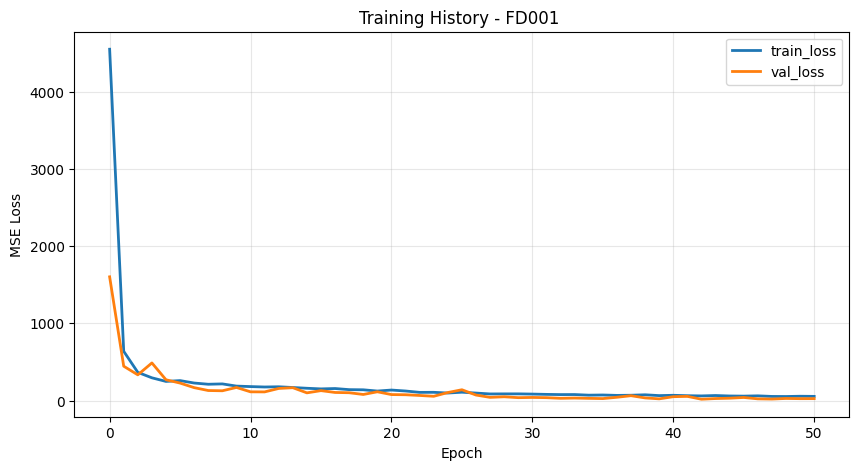

In [10]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="train_loss", linewidth=2)
plt.plot(history.history["val_loss"], label="val_loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training History - FD001 ")
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
#  Evaluate on validation set
y_val_pred = model.predict(X_val, verbose=0).ravel()
rmse_val = math.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = np.mean(np.abs(y_val - y_val_pred))

print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation MAE: {mae_val:.4f}")

Validation RMSE: 4.1658
Validation MAE: 3.2280


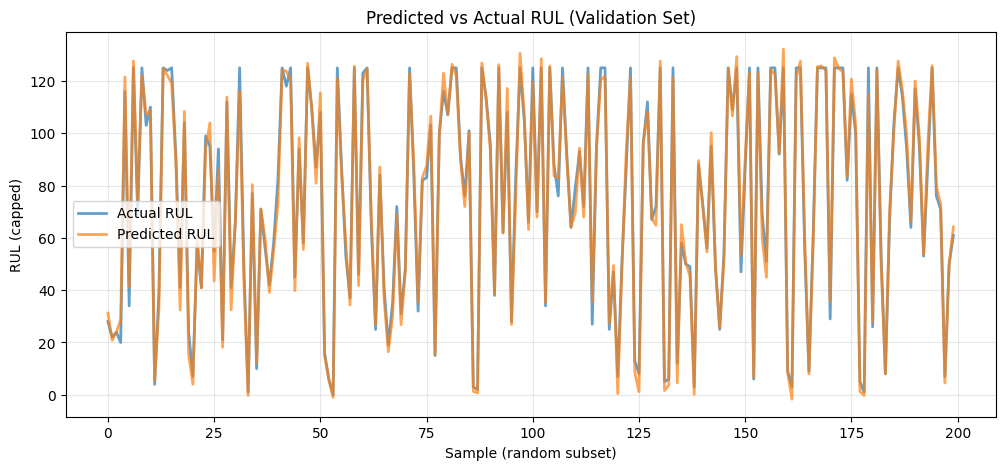

In [12]:
#  Predicted vs Actual plot (random sample)
sample_size = min(200, len(y_val))
idx = np.random.choice(len(y_val), size=sample_size, replace=False)

plt.figure(figsize=(12, 5))
plt.plot(y_val[idx], label="Actual RUL", linewidth=2, alpha=0.7)
plt.plot(y_val_pred[idx], label="Predicted RUL", linewidth=2, alpha=0.7)
plt.xlabel("Sample (random subset)")
plt.ylabel("RUL (capped)")
plt.legend()
plt.title("Predicted vs Actual RUL (Validation Set)")
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Test set evaluation (if test files exist)
if os.path.exists(test_file) and os.path.exists(rul_file):
    print("Loading test data...")
    
    # Read test data
    df_test_raw = read_cmapss(test_file)
    
    # Preprocess test data using the fitted scaler
    df_test_scaled = df_test_raw.copy()
    df_test_scaled[sensor_cols] = scaler.transform(df_test_raw[sensor_cols].values)
    
    # Build test sequences: use last SEQ_LEN cycles for each unit
    X_test = []
    test_units = sorted(df_test_scaled["unit"].unique())
    
    for u in test_units:
        tmp = df_test_scaled[df_test_scaled["unit"] == u].sort_values("cycle")
        arr = tmp[sensor_cols].values
        
        if arr.shape[0] >= SEQ_LEN:
            X_test.append(arr[-SEQ_LEN:])
        else:
            # Pad at front if not enough cycles
            pad_n = SEQ_LEN - arr.shape[0]
            pad = np.tile(arr[0], (pad_n, 1))
            X_test.append(np.vstack([pad, arr]))
    
    X_test = np.array(X_test)
    
    # Load true RUL values
    y_test_true = pd.read_csv(rul_file, sep=r"\s+", header=None).values.ravel()
    
    # Cap RUL the same way as training
    CAP_RUL = 125
    y_test_true = np.clip(y_test_true, a_min=None, a_max=CAP_RUL)
    
    # Make predictions
    y_test_pred = model.predict(X_test, verbose=0).ravel()
    
    # Evaluate
    rmse_test = math.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mae_test = np.mean(np.abs(y_test_true - y_test_pred))
    
    print(f"\nTest RMSE (capped at {CAP_RUL}): {rmse_test:.4f}")
    print(f"Test MAE: {mae_test:.4f}")
    print(f"Test samples: {len(y_test_true)}")
else:
    print("Test files not found!")

Loading test data...


c:\Users\Sneha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Test RMSE (capped at 125): 16.2785
Test MAE: 11.5011
Test samples: 100


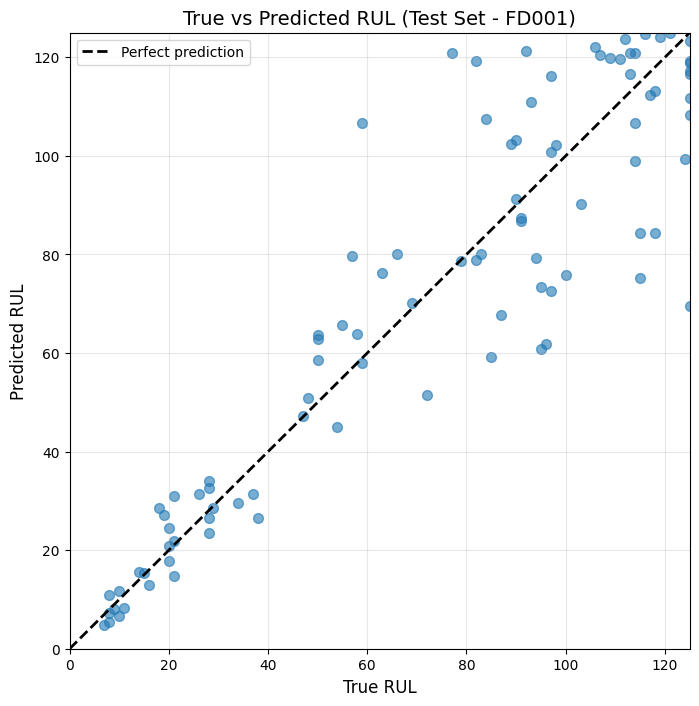

In [14]:
#  Test set scatter plot (True vs Predicted)
if os.path.exists(test_file) and os.path.exists(rul_file):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_true, y_test_pred, alpha=0.6, s=50)
    plt.xlabel("True RUL", fontsize=12)
    plt.ylabel("Predicted RUL", fontsize=12)
    plt.title("True vs Predicted RUL (Test Set - FD001)", fontsize=14)
    plt.plot([0, CAP_RUL], [0, CAP_RUL], "k--", linewidth=2, label="Perfect prediction")
    plt.xlim(0, CAP_RUL)
    plt.ylim(0, CAP_RUL)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Test files not available for visualization")

In [16]:
# Cell 15: Health status alerts for test units
if os.path.exists(test_file) and os.path.exists(rul_file):
    WARNING_THRESHOLD = 30
    CRITICAL_THRESHOLD = 10
    
    def get_alert_status(rul_value):
        """Determine health status based on RUL prediction."""
        if rul_value <= CRITICAL_THRESHOLD:
            return "CRITICAL ⚠️"
        elif rul_value <= WARNING_THRESHOLD:
            return "WARNING ⚠"
        else:
            return "NORMAL ✓"
    
    print("\n" + "="*80)
    print("HEALTH STATUS ALERTS FOR TEST UNITS (FD001)")
    print("="*80)
    print(f"{'Unit':<8} {'True RUL':<12} {'Pred RUL':<12} {'Error':<12} {'Status':<20}")
    print("-"*80)
    
    for i in range(len(test_units)):
        error = abs(y_test_true[i] - y_test_pred[i])
        status = get_alert_status(y_test_pred[i])
        print(f"{test_units[i]:<8} {y_test_true[i]:<12.2f} {y_test_pred[i]:<12.2f} {error:<12.2f} {status:<20}")
    
    print("="*80)
else:
    print("Test files not available for alerts")


HEALTH STATUS ALERTS FOR TEST UNITS (FD001)
Unit     True RUL     Pred RUL     Error        Status              
--------------------------------------------------------------------------------
1        112.00       123.67       11.67        NORMAL ✓            
2        98.00        102.30       4.30         NORMAL ✓            
3        69.00        70.21        1.21         NORMAL ✓            
4        82.00        78.88        3.12         NORMAL ✓            
5        91.00        87.35        3.65         NORMAL ✓            
6        93.00        110.91       17.91        NORMAL ✓            
7        91.00        86.90        4.10         NORMAL ✓            
8        95.00        60.81        34.19        NORMAL ✓            
9        111.00       119.57       8.57         NORMAL ✓            
10       96.00        61.83        34.17        NORMAL ✓            
11       97.00        100.76       3.76         NORMAL ✓            
12       124.00       99.41        24.59      